In [21]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [22]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True,
                               transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True,
                              transform=transforms.ToTensor())

In [23]:
# 2. Poison 10% of the training labels
poison_fraction = .25
num_poisoned = int(poison_fraction * len(train_dataset))

# Get all indices of the training set, then randomly sample 10%
all_indices = list(range(len(train_dataset)))
poisoned_indices = random.sample(all_indices, num_poisoned)

# Overwrite those labels with random values between 0 and 9
for idx in poisoned_indices:
    train_dataset.targets[idx] = random.randint(0, 9)


In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [25]:
# A simple linear model for MNIST
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layer: 1 input channel (grayscale), 32 output channels,
        # kernel size 3x3, stride 1, and padding 1 to maintain input size.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # Max pooling layer: reduces spatial dimensions by a factor of 2.
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layer: input features = 32 channels * 14 * 14 (after pooling a 28x28 image),
        # output features = 10 (for 10 classes).
        self.fc1 = nn.Linear(32 * 14 * 14, 10)
        
    def forward(self, x):
        # Apply convolution, then a ReLU activation.
        x = F.relu(self.conv1(x))
        
        # Apply max pooling to reduce spatial dimensions.
        x = self.pool(x)
        
        # Flatten the tensor while preserving the batch dimension.
        x = torch.flatten(x, 1)
        
        # Pass the flattened tensor through the fully connected layer.
        x = self.fc1(x)
        return x

# Initialize model, loss, optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 20

In [26]:
# Lists to store stats for plotting
train_loss_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_train_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    # Average training loss for this epoch
    train_loss = running_train_loss / len(train_loader)
    train_loss_history.append(train_loss)

    # Evaluation Phase (on test set)
    model.eval()
    running_test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            running_test_loss += loss.item()
            
            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    # Average test loss and accuracy
    test_loss = running_test_loss / len(test_loader)
    test_accuracy = 100.0 * correct / total
    
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | "
          f"Test Loss: {test_loss:.4f} | "
          f"Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/20] Train Loss: 1.4247 | Test Loss: 0.6443 | Test Accuracy: 88.86%
Epoch [2/20] Train Loss: 1.3040 | Test Loss: 0.5968 | Test Accuracy: 91.73%
Epoch [3/20] Train Loss: 1.2750 | Test Loss: 0.5829 | Test Accuracy: 92.19%
Epoch [4/20] Train Loss: 1.2497 | Test Loss: 0.5481 | Test Accuracy: 93.84%
Epoch [5/20] Train Loss: 1.2279 | Test Loss: 0.5122 | Test Accuracy: 94.53%
Epoch [6/20] Train Loss: 1.2093 | Test Loss: 0.4977 | Test Accuracy: 94.98%
Epoch [7/20] Train Loss: 1.1941 | Test Loss: 0.4795 | Test Accuracy: 95.60%
Epoch [8/20] Train Loss: 1.1830 | Test Loss: 0.4722 | Test Accuracy: 95.39%
Epoch [9/20] Train Loss: 1.1742 | Test Loss: 0.4464 | Test Accuracy: 96.29%
Epoch [10/20] Train Loss: 1.1666 | Test Loss: 0.4325 | Test Accuracy: 96.46%
Epoch [11/20] Train Loss: 1.1614 | Test Loss: 0.4397 | Test Accuracy: 96.40%
Epoch [12/20] Train Loss: 1.1557 | Test Loss: 0.4178 | Test Accuracy: 96.70%
Epoch [13/20] Train Loss: 1.1521 | Test Loss: 0.4296 | Test Accuracy: 96.94%
Epoch [1

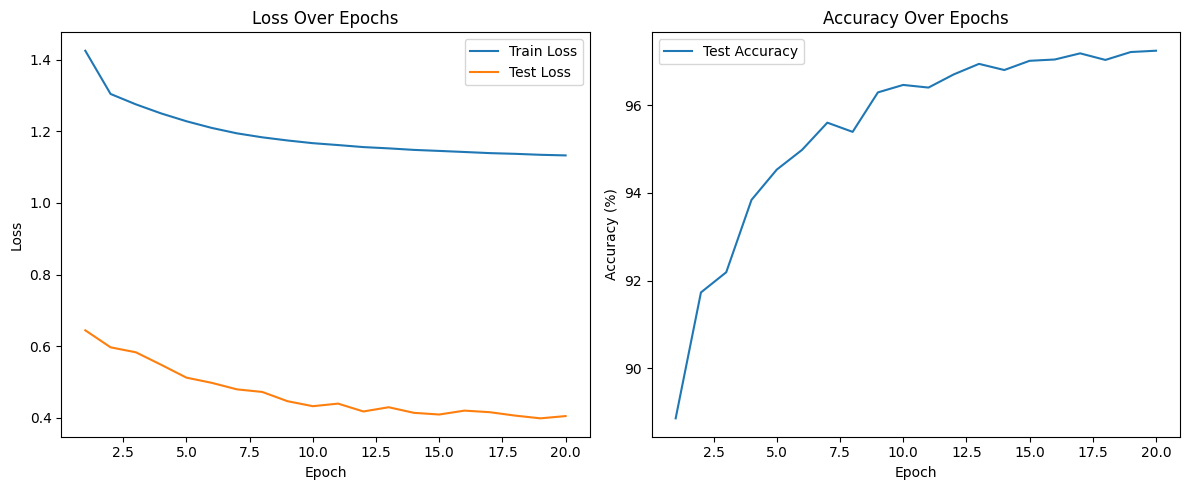

In [27]:
# Plotting
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Train & Test Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Train Loss')
plt.plot(epochs_range, test_loss_history, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_accuracy_history, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()